## author: Keer Mei
- github: kmei92
- email: keer.mei18@imperial.ac.uk

# Setup

In [1]:
# importing the necessary modules
import sys
sys.path.append("..")
from fireframe.PDESystem import *
from fireframe.PDESubsystem import *
from fireframe.pdeforms import *

%load_ext autoreload
%autoreload 2

# Creating pde_solver, a child object from PDESystem

In [2]:
# a PDESystem child class called PDESolver. Note, the setup_constants function and setup_bcs are declared
# and overloaded here and the PDESystem's functions are not used. This is designed for clarity
class pde_solver(PDESystem):
    def __init__(self, comp, mesh, parameters):
        PDESystem.__init__(self, comp, mesh, parameters)

    def setup_bcs(self):
        x, y = fd.SpatialCoordinate(self.mesh)
        c0 = fd.exp(x*y*self.t) # analytical solution to the specific activity of dissolved phase radionuclide
        # one
        
        bcu = [fd.DirichletBC(self.V['u'], fd.Constant((0,0)), (10, 12)), # top-bottom and cylinder
          fd.DirichletBC(self.V['u'], ((1.0*(y - 1)*(2 - y))/(0.5**2) ,0), 9)] # inflow
        bcp = [fd.DirichletBC(self.V['p'], fd.Constant(0), 11)]  # outflow
        bcc1 = [fd.DirichletBC(self.V['c'].sub(0), c0, 'on_boundary')] # maintain a Dirichlet boundary for 
        # radionuclide one concentration

        self.bc['u'][0] = [bcu, None, None, None,'fixed'] # static boundary
        self.bc['p'] = [[bcp, None, None, None, 'fixed']] # static boundary
        self.bc['c'][0] = [bcc1, c0, 'on_boundary', 0, 'update'] # time varying Dirichlet boundary

    def setup_constants(self):
        x, y = fd.SpatialCoordinate(self.mesh)
        
        self.constants = {
            'deltat' : fd.Constant(self.prm['dt']),
            'Kd' : fd.Constant(0.01),
            'k1' : fd.Constant(0.005),
            'k2' : fd.Constant(0.00005),
            'lamd1' : fd.Constant(0.000005),
            'lamd2' : fd.Constant(0.0),
            'rho_s' : fd.Constant(1.),
            'L' :  fd.Constant(1.),
            'phi' : fd.Constant(0.3),
            'n' : fd.FacetNormal(self.mesh),
            'f' : fd.Constant((0.0, 0.0)),
            'nu' : fd.Constant(0.001),
            'frac' : fd.Constant(1.),
        }

# MMS Code Verification

## Spatial discretization

time = 1.000
time = 1.000
time = 1.000
time = 1.000
time = 1.000
time = 1.000
time = 1.000
time = 1.000


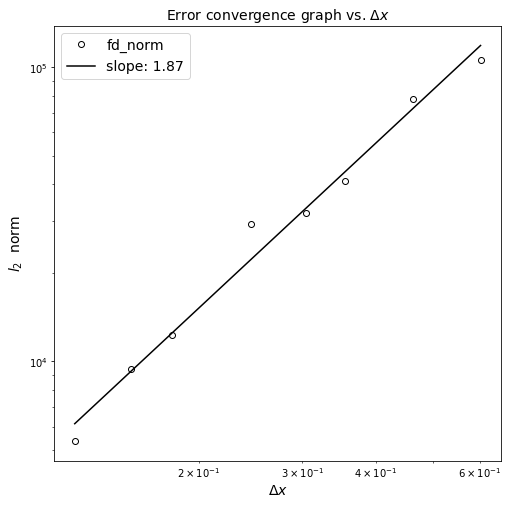

In [10]:
import sympy as sy

# update the parameters
solver_parameters = recursive_update(solver_parameters,
{
'space': {'u': fd.VectorFunctionSpace, 'c': fd.MixedFunctionSpace, 'd' : fd.MixedFunctionSpace},
'degree': {'u': 2},
'order' : {'c': 3, 'd':3},
'ksp_type': {'u': 'gmres', 'p': 'gmres',  'c': 'gmres', 'd':'gmres'},
'precond': {'u': 'sor', 'p' : 'sor', 'c': 'sor', 'd':'gmres'},
'dt' : 0.001,
'T' : 1.5})

#load mesh
mesh = fd.Mesh("../meshes/step1.msh")

# add subsystems for navier stokes and radio_transport
solver = pde_solver([['u', 'p']], mesh, solver_parameters)
# solver.add_subsystem(['cd', 'cs', 'as'], solver_parameters)
solver.add_subsystem(['c', 'd'], solver_parameters)
#setup constants
solver.setup_constants()
# define subsystems and variable sequence
solver.define(['u', 'p', 'u'], 'up', navier_stokes)
solver.define(['c', 'd'], 'cd', radio_transport_coupled_mms)
# setup boundary conditions
solver.setup_bcs()
x, y, t = sy.symbols(('x', 'y', 't'))
expr = sy.exp(x*y*t)
meshes = [fd.Mesh("../meshes/step%d.msh" % i) for i in range(1, 9)]
solver.test_mms('c', expr, spatial=True, f_dict={"exp":fd.exp}, meshes=meshes, plot=True, index=0)

## Temporal discretization

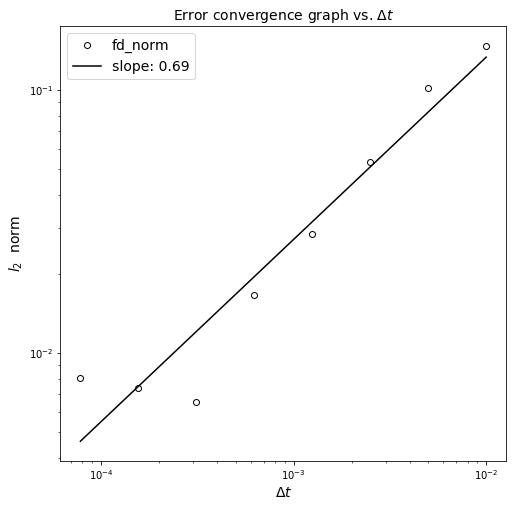

In [8]:
# update the parameters
solver_parameters = recursive_update(solver_parameters,
{
'space': {'u': fd.VectorFunctionSpace, 'c': fd.MixedFunctionSpace, 'd' : fd.MixedFunctionSpace},
'degree': {'u': 2},
'order' : {'c': 3, 'd':3},
'ksp_type': {'u': 'gmres', 'p': 'gmres',  'c': 'gmres', 'd':'gmres'},
'precond': {'u': 'sor', 'p' : 'sor', 'c': 'sor', 'd':'gmres'},
'dt' : 0.01,
'T' : 0.1})

#load mesh
mesh = fd.Mesh("../meshes/step1.msh")
deltat = [0.01 / (2**i) for i in range(8)]

# add subsystems for navier stokes and radio_transport
solver = pde_solver([['u', 'p']], mesh, solver_parameters)
# solver.add_subsystem(['cd', 'cs', 'as'], solver_parameters)
solver.add_subsystem(['c', 'd'], solver_parameters)
#setup constants
solver.setup_constants()
# define subsystems and variable sequence
solver.define(['u', 'p', 'u'], 'up', navier_stokes)
solver.define(['c', 'd'], 'cd', radio_transport_coupled_mms)
# setup boundary conditions
solver.setup_bcs()

x, y, t = sy.symbols(('x', 'y', 't'))
expr = sy.exp(x*y*t)
solver.test_mms('c', expr, temporal=True, f_dict={"exp":fd.exp}, dt_list=deltat, plot=True, index=0)

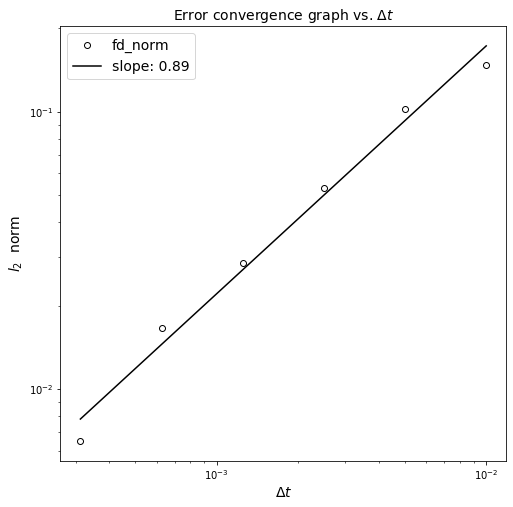

In [7]:
# update the parameters
solver_parameters = recursive_update(solver_parameters,
{
'space': {'u': fd.VectorFunctionSpace, 'c': fd.MixedFunctionSpace, 'd' : fd.MixedFunctionSpace},
'degree': {'u': 2},
'order' : {'c': 3, 'd':3},
'ksp_type': {'u': 'gmres', 'p': 'gmres',  'c': 'gmres', 'd':'gmres'},
'precond': {'u': 'sor', 'p' : 'sor', 'c': 'sor', 'd':'gmres'},
'dt' : 0.01,
'T' : 0.1})

#load mesh
mesh = fd.Mesh("../meshes/step1.msh")
deltat = [0.01 / (2**i) for i in range(6)]

# add subsystems for navier stokes and radio_transport
solver = pde_solver([['u', 'p']], mesh, solver_parameters)
# solver.add_subsystem(['cd', 'cs', 'as'], solver_parameters)
solver.add_subsystem(['c', 'd'], solver_parameters)
#setup constants
solver.setup_constants()
# define subsystems and variable sequence
solver.define(['u', 'p', 'u'], 'up', navier_stokes)
solver.define(['c', 'd'], 'cd', radio_transport_coupled_mms)
# setup boundary conditions
solver.setup_bcs()

x, y, t = sy.symbols(('x', 'y', 't'))
expr = sy.exp(x*y*t)
solver.test_mms('c', expr, temporal=True, f_dict={"exp":fd.exp}, dt_list=deltat, plot=True, index=0)